# Predictive Analytics

To get a better understanding of the dynamics in the field of ride-hailing in Chicago, we want to employ Support Vector Machines and Neural Networks to predict the taxi demand in spatio-temporal resolution.
This notebook is structured as follows:
* Import necessary python libraries and files
* Construction of the final feature sets
* Predictive Analytics (SVMs and Neural Networks)

Since we use large datasets it could appear that we run into some memory issues. Therefore, we designed this notebook in a way, that the feature set construction and the predictive analytics could be run independently from one another. For that, the saved files from the first part will be imported again at the beginning of the second part.

### Import libraries

In [1]:
# Import necessary libraries
!pip install h3
import pandas as pd
import h3

import gc

import warnings
warnings.filterwarnings('ignore')

### Import files

First, we need to import the Chicago taxi trip dataset from 2013 and the additional weather dataset that contains hourly weather data. The extended trips dataset, that was created in the Feature Engineering notebook, contains all relevant features, that we will use/try out in the prediction.

In [2]:
# Import necessary pickle datasets after preprocessing
trips_2013 = pd.read_pickle("data/trips_2013_extended.pkl")
weather_hourly = pd.read_pickle("data/weather_hourly.pkl")

In [3]:
trips_2013.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6448673 entries, 0 to 6448672
Data columns (total 36 columns):
 #   Column              Dtype         
---  ------              -----         
 0   trip_id             object        
 1   taxi_id             object        
 2   start_time          datetime64[ns]
 3   end_time            datetime64[ns]
 4   duration            float64       
 5   hour                int64         
 6   day                 object        
 7   week_day            int64         
 8   part_of_day         object        
 9   is_weekend          int64         
 10  month               int64         
 11  start_location      object        
 12  start_lat           float64       
 13  start_long          float64       
 14  end_location        object        
 15  end_lat             float64       
 16  end_long            float64       
 17  h3_hex_6            object        
 18  h3_hex_7            object        
 19  h3_hex_8            object        
 20  st

### Construction of the final feature sets

As a basis for the construction of the final feature set, we want to extract the date related features that we will try for the prediction. The columns, that we use from the trips dataset, are: start_census_tract/h3, day, hour, week_day, month, poi_count_start, airport_trip, is_holiday, is_special_date.

Finally, we construct the feature sets for the four temporal resoulutions (hourly, two-hourly, six-hourly, and daily) and the spacial resolutions (census tract and h3 with three different resolutions).

In [4]:
# Add some date related columns to the weather dataset
weather_hourly['hour'] = weather_hourly['datetime'].dt.hour
weather_hourly['day'] = weather_hourly['datetime'].dt.strftime('%Y-%m-%d')
weather_hourly['day'] = pd.to_datetime(weather_hourly['day'])
weather_hourly['weekday'] = weather_hourly['datetime'].dt.day_of_week
weather_hourly['month'] = weather_hourly['datetime'].dt.month
weather_hourly['temperature'] = weather_hourly['temperature'].round(0)

# Convert the day column to datetime object in order to be able to join it with the weather dataset
trips_2013['day'] = pd.to_datetime(trips_2013['day'])

#### Hourly Feature Sets

We decided to represent the taxi demand as the total number of trips for a given spacial and temporal resolution.

For the hourly feature set we select the spacial resolution (census tract or h3) and group the dataframe by the columns *spacial resolution*, day, and hour to then calculate the number of total trips. We also keep weather data about the day, hour, temperature, and if it rained or not (precipitation) from the hourly weather dataset.

In [5]:
# Extract relevant data from trips_2013 and weather_hourly datasets and define the 'trips' column as the total number of trips per spacial resolution and hour

# For cencus tract
number_of_trips_ct = trips_2013[['start_census_tract','day','hour','week_day','month','poi_count_start','airport_trip','is_holiday','is_special_date']]
trip_counts = trips_2013.groupby(['start_census_tract', 'day', 'hour']).size().reset_index(name='trips')
number_of_trips_ct = number_of_trips_ct.merge(trip_counts, on=['start_census_tract', 'day', 'hour'], how='left')
number_of_trips_ct.drop_duplicates(inplace=True)
number_of_trips_ct = number_of_trips_ct.sort_values(by=['start_census_tract', 'day', 'hour'])
number_of_trips_ct.reset_index(drop=True,inplace=True)

# For h3 res=6
number_of_trips_h3_6 = trips_2013[['h3_hex_6','day','hour','week_day','month','poi_count_start','airport_trip','is_holiday','is_special_date']]
trip_counts = trips_2013.groupby(['h3_hex_6', 'day', 'hour']).size().reset_index(name='trips')
number_of_trips_h3_6 = number_of_trips_h3_6.merge(trip_counts, on=['h3_hex_6', 'day', 'hour'], how='left')
number_of_trips_h3_6.drop_duplicates(inplace=True)
number_of_trips_h3_6 = number_of_trips_h3_6.sort_values(by=['h3_hex_6', 'day', 'hour'])
number_of_trips_h3_6.reset_index(drop=True,inplace=True)

# For h3 res=7
number_of_trips_h3_7 = trips_2013[['h3_hex_7','day','hour','week_day','month','poi_count_start','airport_trip','is_holiday','is_special_date']]
trip_counts = trips_2013.groupby(['h3_hex_7', 'day', 'hour']).size().reset_index(name='trips')
number_of_trips_h3_7 = number_of_trips_h3_7.merge(trip_counts, on=['h3_hex_7', 'day', 'hour'], how='left')
number_of_trips_h3_7.drop_duplicates(inplace=True)
number_of_trips_h3_7 = number_of_trips_h3_7.sort_values(by=['h3_hex_7', 'day', 'hour'])
number_of_trips_h3_7.reset_index(drop=True,inplace=True)

# For h3 res=8
number_of_trips_h3_8 = trips_2013[['h3_hex_8','day','hour','week_day','month','poi_count_start','airport_trip','is_holiday','is_special_date']]
trip_counts = trips_2013.groupby(['h3_hex_8', 'day', 'hour']).size().reset_index(name='trips')
number_of_trips_h3_8 = number_of_trips_h3_8.merge(trip_counts, on=['h3_hex_8', 'day', 'hour'], how='left')
number_of_trips_h3_8.drop_duplicates(inplace=True)
number_of_trips_h3_8 = number_of_trips_h3_8.sort_values(by=['h3_hex_8', 'day', 'hour'])
number_of_trips_h3_8.reset_index(drop=True,inplace=True)

# For weather data: extract the columns day, hour, temperature, and precip from the hourly weather dataset
weather_features = weather_hourly[['day','hour','temperature','precip']]

Now we define functions for joining the census tract or h3 dataframes with the weather dataframe. The functions are needed because we have to do this several times in this notebook.

In [6]:
# Join datasets for census tract
def join_census_tract(census, weather):
  temp_dataset = pd.DataFrame()

  # Iterate over unique start_census_tract values
  for start_census_tract in census['start_census_tract'].unique():
      # Select data for the current start_census_tract group
      group_data = census[census['start_census_tract'] == start_census_tract]

      # Merge the group data with the hourly weather dataset
      if 'hour' in census.columns:
        merged_group_data = group_data.merge(weather, on=['day', 'hour'], how='inner')
      else: # For the daily feature set as it doesn't contain the hour column
        merged_group_data = group_data.merge(weather, on=['day'], how='inner')

      # Append the merged group data to the overall merged dataframe
      temp_dataset = temp_dataset.append(merged_group_data)

  temp_dataset.reset_index(drop=True, inplace=True)
  return temp_dataset

In [7]:
# Join datasets for h3 res=6
def join_h3_6(h3_6, weather):
  temp6 = pd.DataFrame()

  # Iterate over unique h3_hex_6 values
  for h3_hex_6 in h3_6['h3_hex_6'].unique():
      # Select data for the current start_census_tract group
      group_data = h3_6[h3_6['h3_hex_6'] == h3_hex_6]

      # Merge the group data with the hourly weather dataset
      if 'hour' in h3_6.columns:
        merged_group_data = group_data.merge(weather, on=['day', 'hour'], how='inner')
      else: # For the daily feature set as it doesn't contain the hour column
        merged_group_data = group_data.merge(weather, on=['day'], how='inner')

      # Append the merged group data to the overall merged dataframe
      temp6 = temp6.append(merged_group_data)

  temp6.reset_index(drop=True, inplace=True)
  return temp6

In [8]:
# Join datasets for h3 res=7
def join_h3_7(h3_7, weather):
  temp_7 = pd.DataFrame()

  # Iterate over unique h3_hex_7 values
  for h3_hex_7 in h3_7['h3_hex_7'].unique():
      # Select data for the current start_census_tract group
      group_data = h3_7[h3_7['h3_hex_7'] == h3_hex_7]

      # Merge the group data with the hourly weather dataset
      if 'hour' in h3_7.columns:
        merged_group_data = group_data.merge(weather, on=['day', 'hour'], how='inner')
      else: # For the daily feature set as it doesn't contain the hour column
        merged_group_data = group_data.merge(weather, on=['day'], how='inner')

      # Append the merged group data to the overall merged dataframe
      temp_7 = temp_7.append(merged_group_data)

  temp_7.reset_index(drop=True, inplace=True)
  return temp_7

In [9]:
# Join datasets for h3 res=8
def join_h3_8(h3_8, weather):
  temp_8 = pd.DataFrame()

  # Iterate over unique h3_hex_8 values
  for h3_hex_8 in h3_8['h3_hex_8'].unique():
    # Select data for the current start_census_tract group
    group_data = h3_8[h3_8['h3_hex_8'] == h3_hex_8]

    # Merge the group data with the hourly weather dataset
    if 'hour' in h3_8.columns:
      merged_group_data = group_data.merge(weather, on=['day', 'hour'], how='inner')
    else: # For the daily feature set as it doesn't contain the hour column
      merged_group_data = group_data.merge(weather, on=['day'], how='inner')

    # Append the merged group data to the overall merged dataframe
    temp_8 = temp_8.append(merged_group_data)

  temp_8.reset_index(drop=True, inplace=True)
  return temp_8

In [10]:
# Performing the join for the hourly feature sets
feature_set_hourly_ct = join_census_tract(number_of_trips_ct, weather_features)
feature_set_hourly_h3_6 = join_h3_6(number_of_trips_h3_6, weather_features)
feature_set_hourly_h3_7 = join_h3_7(number_of_trips_h3_7, weather_features)
feature_set_hourly_h3_8 = join_h3_8(number_of_trips_h3_8, weather_features)

This is what the hourly feature sets look like:

In [11]:
feature_set_hourly_ct.head()

,start_census_tract,day,hour,week_day,month,poi_count_start,airport_trip,is_holiday,is_special_date,trips,temperature,precip
0,17031010100,2013-04-21,1,6,4,0.0,0,0,0,1,2.0,0
1,17031010100,2013-12-06,19,4,12,0.0,0,0,0,1,-6.0,0
2,17031010201,2013-02-16,19,5,2,1.0,0,0,0,1,-1.0,0
3,17031010201,2013-03-01,6,4,3,1.0,0,0,0,1,1.0,0
4,17031010201,2013-03-01,20,4,3,1.0,0,0,0,1,1.0,0


In [12]:
feature_set_hourly_h3_6.head()

,h3_hex_6,day,hour,week_day,month,poi_count_start,airport_trip,is_holiday,is_special_date,trips,temperature,precip
0,862664527ffffff,2013-01-01,10,1,1,1.0,1,1,0,1,1.0,0
1,862664527ffffff,2013-01-01,11,1,1,1.0,1,1,0,3,1.0,0
2,862664527ffffff,2013-01-01,12,1,1,1.0,1,1,0,4,1.0,0
3,862664527ffffff,2013-01-01,13,1,1,1.0,1,1,0,5,1.0,0
4,862664527ffffff,2013-01-01,14,1,1,1.0,1,1,0,3,1.0,0


In [13]:
# Save hourly feature sets as pickle
feature_set_hourly_ct.to_pickle('data/feature_set_hourly_ct.pkl')
feature_set_hourly_h3_6.to_pickle('data/feature_set_hourly_h3_6.pkl')
feature_set_hourly_h3_7.to_pickle('data/feature_set_hourly_h3_7.pkl')
feature_set_hourly_h3_8.to_pickle('data/feature_set_hourly_h3_8.pkl')

In [14]:
# Clear variables
del feature_set_hourly_ct, feature_set_hourly_h3_6, feature_set_hourly_h3_7, feature_set_hourly_h3_8

#### 2-hourly Feature Sets

For the two-hourly feature sets we apply the steps from above and use the previously defined functions. Two adjustmens are made here: we have to map the hours to two-hour intervals and therefore we need to adjust the data for temperature and precipitation.

In [15]:
# Function to map hour to the desired two-hour interval
def map_to_2_hour_interval(hour):
    return hour//2

First, we need to map the hours to the new two-hour intervals. We defined a function above that will return values between 0 and 11. This creates 12 two-hour intervals as desired. Of course, this function is applied to the weather dataframe as well.

In [16]:
trips_2013['hour'] = trips_2013['start_time'].dt.hour.apply(map_to_2_hour_interval)
weather_hourly['hour'] = weather_hourly['datetime'].dt.hour.apply(map_to_2_hour_interval)

# Print out the resulting intervals
print(trips_2013['hour'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11]


Now we have to adjust the temperature and precipitation data for the corresponding two-hour intervals. It is possible that the two-hour intervals include different values for the temperature and precipitation in the original trips dataframe.

For the temperature we decided to calculate the mean temperature of the two hours and set it as the temperature for the new two-hour interval. For the precipitation we use the maximum value for precipitation as the new value for the two-hour interval. As the column only includes 0 and 1 values, this means that the value for the new interval is set to 1, if it rained in any of the two hours.

In [17]:
# Group by the 'day' and 'hour' columns and calculate the mean temperature and maximum precip value for each 2-hour interval
mean_temperatures = weather_hourly.groupby(['day','hour'])['temperature'].mean().reset_index()
max_precip = weather_hourly.groupby(['day', 'hour'])['precip'].max().reset_index()

# Merge the mean temperatures and maximum precip values back to the weather_hourly dataset based on the 'day' and 'hour' columns
weather_hourly = weather_hourly.merge(mean_temperatures, on=['day', 'hour'], suffixes=('', '_mean'))
weather_hourly = weather_hourly.merge(max_precip, on=['day', 'hour'], suffixes=('', '_max'))

# Update the 'temperature' and 'precip' columns with the calculated values and round the temperature to the nearest integer
weather_hourly['temperature'] = weather_hourly['temperature_mean'].round(0)
weather_hourly['precip'] = weather_hourly['precip_max']

# Drop the extra columns
weather_hourly.drop(columns=['temperature_mean', 'precip_max'], inplace=True)

In [18]:
# Like above: create the dataframes, extract relevant trip and weather data and calculate the number of trips

# For cencus tract
number_of_trips_ct = trips_2013[['start_census_tract','day','hour','week_day','month','poi_count_start','airport_trip','is_holiday','is_special_date']]
trip_counts = trips_2013.groupby(['start_census_tract', 'day', 'hour']).size().reset_index(name='trips')
number_of_trips_ct = number_of_trips_ct.merge(trip_counts, on=['start_census_tract', 'day', 'hour'], how='left')
number_of_trips_ct.drop_duplicates(inplace=True)
number_of_trips_ct = number_of_trips_ct.sort_values(by=['start_census_tract', 'day', 'hour'])
number_of_trips_ct.reset_index(drop=True,inplace=True)

# For h3 res=6
number_of_trips_h3_6 = trips_2013[['h3_hex_6','day','hour','week_day','month','poi_count_start','airport_trip','is_holiday','is_special_date']]
trip_counts = trips_2013.groupby(['h3_hex_6', 'day', 'hour']).size().reset_index(name='trips')
number_of_trips_h3_6 = number_of_trips_h3_6.merge(trip_counts, on=['h3_hex_6', 'day', 'hour'], how='left')
number_of_trips_h3_6.drop_duplicates(inplace=True)
number_of_trips_h3_6 = number_of_trips_h3_6.sort_values(by=['h3_hex_6', 'day', 'hour'])
number_of_trips_h3_6.reset_index(drop=True,inplace=True)

# For h3 res=7
number_of_trips_h3_7 = trips_2013[['h3_hex_7','day','hour','week_day','month','poi_count_start','airport_trip','is_holiday','is_special_date']]
trip_counts = trips_2013.groupby(['h3_hex_7', 'day', 'hour']).size().reset_index(name='trips')
number_of_trips_h3_7 = number_of_trips_h3_7.merge(trip_counts, on=['h3_hex_7', 'day', 'hour'], how='left')
number_of_trips_h3_7.drop_duplicates(inplace=True)
number_of_trips_h3_7 = number_of_trips_h3_7.sort_values(by=['h3_hex_7', 'day', 'hour'])
number_of_trips_h3_7.reset_index(drop=True,inplace=True)

# For h3 res=8
number_of_trips_h3_8 = trips_2013[['h3_hex_8','day','hour','week_day','month','poi_count_start','airport_trip','is_holiday','is_special_date']]
trip_counts = trips_2013.groupby(['h3_hex_8', 'day', 'hour']).size().reset_index(name='trips')
number_of_trips_h3_8 = number_of_trips_h3_8.merge(trip_counts, on=['h3_hex_8', 'day', 'hour'], how='left')
number_of_trips_h3_8.drop_duplicates(inplace=True)
number_of_trips_h3_8 = number_of_trips_h3_8.sort_values(by=['h3_hex_8', 'day', 'hour'])
number_of_trips_h3_8.reset_index(drop=True,inplace=True)

# For weather data: extract the columns day, hour, temperature, and precip from the hourly weather dataset
weather_features = weather_hourly[['day','hour','temperature','precip']]
weather_features.drop_duplicates(inplace=True)

In [19]:
# Clear trips and weather variable
del trips_2013, weather_hourly

In [20]:
# Performing the join for the two-hourly feature sets
feature_set_2hourly_ct = join_census_tract(number_of_trips_ct, weather_features)
feature_set_2hourly_h3_6 = join_h3_6(number_of_trips_h3_6, weather_features)
feature_set_2hourly_h3_7 = join_h3_7(number_of_trips_h3_7, weather_features)
feature_set_2hourly_h3_8 = join_h3_8(number_of_trips_h3_8, weather_features)

This is what the two-hourly feature sets look like:

In [21]:
feature_set_2hourly_ct.head()

,start_census_tract,day,hour,week_day,month,poi_count_start,airport_trip,is_holiday,is_special_date,trips,temperature,precip
0,17031010100,2013-04-21,0,6,4,0.0,0,0,0,1,2.0,0
1,17031010100,2013-12-06,9,4,12,0.0,0,0,0,1,-6.0,0
2,17031010201,2013-02-16,9,5,2,1.0,0,0,0,1,-1.0,0
3,17031010201,2013-03-01,3,4,3,1.0,0,0,0,1,1.0,0
4,17031010201,2013-03-01,10,4,3,1.0,0,0,0,1,1.0,0


In [22]:
feature_set_2hourly_h3_7.head()

,h3_hex_7,day,hour,week_day,month,poi_count_start,airport_trip,is_holiday,is_special_date,trips,temperature,precip
0,872664520ffffff,2013-12-13,1,4,12,0.0,0,0,0,1,-8.0,0
1,872664521ffffff,2013-01-01,5,1,1,1.0,1,1,0,4,1.0,0
2,872664521ffffff,2013-01-01,6,1,1,1.0,1,1,0,9,1.0,0
3,872664521ffffff,2013-01-01,7,1,1,1.0,1,1,0,9,2.0,0
4,872664521ffffff,2013-01-01,8,1,1,1.0,1,1,0,8,2.0,0


In [23]:
# Save two-hourly feature sets as pickle
feature_set_2hourly_ct.to_pickle('data/feature_set_2hourly_ct.pkl')
feature_set_2hourly_h3_6.to_pickle('data/feature_set_2hourly_h3_6.pkl')
feature_set_2hourly_h3_7.to_pickle('data/feature_set_2hourly_h3_7.pkl')
feature_set_2hourly_h3_8.to_pickle('data/feature_set_2hourly_h3_8.pkl')

In [24]:
# Clear variables
del feature_set_2hourly_ct, feature_set_2hourly_h3_6, feature_set_2hourly_h3_7, feature_set_2hourly_h3_8
gc.collect()

0

#### 6-hourly Feature Sets

Now we repeat the same steps from before to get the six-hour interval feature sets.

In [25]:
# Function to map hour to the desired six-hour interval
def map_to_6_hour_interval(hour):
    return hour//6

We have to import the trips and weather datasets again because we modified the dataframes in the previous steps for the two-hour interval data.

In [26]:
# Import necessary pickle datasets after preprocessing
trips_2013 = pd.read_pickle("data/trips_2013_extended.pkl")
weather_hourly = pd.read_pickle("data/weather_hourly.pkl")

In [27]:
# Add some date related columns to the weather dataset
weather_hourly['hour'] = weather_hourly['datetime'].dt.hour
weather_hourly['day'] = weather_hourly['datetime'].dt.strftime('%Y-%m-%d')
weather_hourly['day'] = pd.to_datetime(weather_hourly['day'])
weather_hourly['weekday'] = weather_hourly['datetime'].dt.day_of_week
weather_hourly['month'] = weather_hourly['datetime'].dt.month
weather_hourly['temperature'] = weather_hourly['temperature'].round(0)

trips_2013['day'] = pd.to_datetime(trips_2013['day'])

As we map the hours in the trips and weather dataframes to the corresponding six-hour intervals, we get the 4 six-hour intervals as expected.

In [28]:
trips_2013['hour'] = trips_2013['start_time'].dt.hour.apply(map_to_6_hour_interval)
weather_hourly['hour'] = weather_hourly['datetime'].dt.hour.apply(map_to_6_hour_interval)

# Print out the resulting intervals
print(trips_2013['hour'].unique())

[0 1 2 3]


In [29]:
# Group by the 'day' and 'hour' columns and calculate the mean temperature and maximum precip value for each six-hour interval
mean_temperatures = weather_hourly.groupby(['day','hour'])['temperature'].mean().reset_index()
max_precip = weather_hourly.groupby(['day', 'hour'])['precip'].max().reset_index()

# Merge the mean temperatures and maximum precip values back to the weather_hourly dataset based on the 'day' and 'hour' columns
weather_hourly = weather_hourly.merge(mean_temperatures, on=['day', 'hour'], suffixes=('', '_mean'))
weather_hourly = weather_hourly.merge(max_precip, on=['day', 'hour'], suffixes=('', '_max'))

# Update the 'temperature' and 'precip' columns with the calculated values and round the temperature to the nearest integer
weather_hourly['temperature'] = weather_hourly['temperature_mean'].round(0)
weather_hourly['precip'] = weather_hourly['precip_max']

# Drop the extra columns
weather_hourly.drop(columns=['temperature_mean', 'precip_max'], inplace=True)

In [30]:
# Like above: create the dataframes, extract relevant trip and weather data and calculate the number of trips

# For cencus tract
number_of_trips_ct = trips_2013[['start_census_tract','day','hour','week_day','month','poi_count_start','airport_trip','is_holiday','is_special_date']]
trip_counts = trips_2013.groupby(['start_census_tract', 'day', 'hour']).size().reset_index(name='trips')
number_of_trips_ct = number_of_trips_ct.merge(trip_counts, on=['start_census_tract', 'day', 'hour'], how='left')
number_of_trips_ct.drop_duplicates(inplace=True)
number_of_trips_ct = number_of_trips_ct.sort_values(by=['start_census_tract', 'day', 'hour'])
number_of_trips_ct.reset_index(drop=True,inplace=True)

# For h3 res=6
number_of_trips_h3_6 = trips_2013[['h3_hex_6','day','hour','week_day','month','poi_count_start','airport_trip','is_holiday','is_special_date']]
trip_counts = trips_2013.groupby(['h3_hex_6', 'day', 'hour']).size().reset_index(name='trips')
number_of_trips_h3_6 = number_of_trips_h3_6.merge(trip_counts, on=['h3_hex_6', 'day', 'hour'], how='left')
number_of_trips_h3_6.drop_duplicates(inplace=True)
number_of_trips_h3_6 = number_of_trips_h3_6.sort_values(by=['h3_hex_6', 'day', 'hour'])
number_of_trips_h3_6.reset_index(drop=True,inplace=True)

# For h3 res=7
number_of_trips_h3_7 = trips_2013[['h3_hex_7','day','hour','week_day','month','poi_count_start','airport_trip','is_holiday','is_special_date']]
trip_counts = trips_2013.groupby(['h3_hex_7', 'day', 'hour']).size().reset_index(name='trips')
number_of_trips_h3_7 = number_of_trips_h3_7.merge(trip_counts, on=['h3_hex_7', 'day', 'hour'], how='left')
number_of_trips_h3_7.drop_duplicates(inplace=True)
number_of_trips_h3_7 = number_of_trips_h3_7.sort_values(by=['h3_hex_7', 'day', 'hour'])
number_of_trips_h3_7.reset_index(drop=True,inplace=True)

# For h3 res=8
number_of_trips_h3_8 = trips_2013[['h3_hex_8','day','hour','week_day','month','poi_count_start','airport_trip','is_holiday','is_special_date']]
trip_counts = trips_2013.groupby(['h3_hex_8', 'day', 'hour']).size().reset_index(name='trips')
number_of_trips_h3_8 = number_of_trips_h3_8.merge(trip_counts, on=['h3_hex_8', 'day', 'hour'], how='left')
number_of_trips_h3_8.drop_duplicates(inplace=True)
number_of_trips_h3_8 = number_of_trips_h3_8.sort_values(by=['h3_hex_8', 'day', 'hour'])
number_of_trips_h3_8.reset_index(drop=True,inplace=True)

# For weather data: extract the columns day, hour, temperature, and precip from the hourly weather dataset
weather_features = weather_hourly[['day','hour','temperature','precip']]
weather_features.drop_duplicates(inplace=True)

In [31]:
# Clear trips and weather variable
del trips_2013, weather_hourly

In [32]:
# Performing the join for the 6-hourly feature sets
feature_set_6hourly_ct = join_census_tract(number_of_trips_ct, weather_features)
feature_set_6hourly_h3_6 = join_h3_6(number_of_trips_h3_6, weather_features)
feature_set_6hourly_h3_7 = join_h3_7(number_of_trips_h3_7, weather_features)
feature_set_6hourly_h3_8 = join_h3_8(number_of_trips_h3_8, weather_features)

This is what the six-hourly feature sets look like:

In [33]:
feature_set_6hourly_ct.head()

,start_census_tract,day,hour,week_day,month,poi_count_start,airport_trip,is_holiday,is_special_date,trips,temperature,precip
0,17031010100,2013-04-21,0,6,4,0.0,0,0,0,1,2.0,1
1,17031010100,2013-12-06,3,4,12,0.0,0,0,0,1,-6.0,0
2,17031010201,2013-02-16,3,5,2,1.0,0,0,0,1,-1.0,0
3,17031010201,2013-03-01,1,4,3,1.0,0,0,0,1,1.0,0
4,17031010201,2013-03-01,3,4,3,1.0,0,0,0,1,1.0,1


In [34]:
feature_set_6hourly_h3_8.head()

,h3_hex_8,day,hour,week_day,month,poi_count_start,airport_trip,is_holiday,is_special_date,trips,temperature,precip
0,8826645215fffff,2013-09-13,1,4,9,1.0,0,0,0,1,16.0,1
1,8826645215fffff,2013-11-01,1,4,11,1.0,0,0,0,1,8.0,1
2,8826645219fffff,2013-01-01,1,1,1,1.0,1,1,0,4,1.0,0
3,8826645219fffff,2013-01-01,2,1,1,1.0,1,1,0,26,1.0,0
4,8826645219fffff,2013-01-01,3,1,1,1.0,1,1,0,39,-0.0,0


In [35]:
# Save six-hourly feature sets as pickle
feature_set_6hourly_ct.to_pickle('data/feature_set_6hourly_ct.pkl')
feature_set_6hourly_h3_6.to_pickle('data/feature_set_6hourly_h3_6.pkl')
feature_set_6hourly_h3_7.to_pickle('data/feature_set_6hourly_h3_7.pkl')
feature_set_6hourly_h3_8.to_pickle('data/feature_set_6hourly_h3_8.pkl')

In [36]:
# Clear variables
del feature_set_6hourly_ct, feature_set_6hourly_h3_6, feature_set_6hourly_h3_7, feature_set_6hourly_h3_8
gc.collect()

0

#### 24-hourly/daily Feature Sets

For the 24-hourly/daily feature sets we again need to import the trips dataset as we modified it before. Now, we import the daily weather dataset instead of the hourly weather dataset to save some time and shorten the code.

The additional date related columns are the same as before for now. The important difference for the daily feature sets will be made here.

In [37]:
# Import necessary pickle datasets after preprocessing
trips_2013 = pd.read_pickle("data/trips_2013_extended.pkl")
weather_daily = pd.read_pickle("data/weather_daily.pkl")

In [38]:
# Add some date related columns to the weather dataset
weather_daily['hour'] = weather_daily['datetime'].dt.hour
weather_daily['day'] = weather_daily['datetime'].dt.strftime('%Y-%m-%d')
weather_daily['day'] = pd.to_datetime(weather_daily['day'])
weather_daily['weekday'] = weather_daily['datetime'].dt.day_of_week
weather_daily['month'] = weather_daily['datetime'].dt.month
weather_daily['temperature'] = weather_daily['temperature'].round(0)

trips_2013['day'] = pd.to_datetime(trips_2013['day'])

When constructing the dataframes that contain the number of trips and the weather data, the day is the only date related column that will be included. The hour is no longer added here. This results in dataframes that capture the 24-hourly/daily intervals.

In [39]:
# Like above: create the dataframes, extract relevant trip and weather data and calculate the number of trips

# For cencus tract
number_of_trips_ct = trips_2013[['start_census_tract','day','week_day','month','poi_count_start','airport_trip','is_holiday','is_special_date']]
trip_counts = trips_2013.groupby(['start_census_tract', 'day']).size().reset_index(name='trips')
number_of_trips_ct = number_of_trips_ct.merge(trip_counts, on=['start_census_tract', 'day'], how='left')
number_of_trips_ct.drop_duplicates(inplace=True)
number_of_trips_ct = number_of_trips_ct.sort_values(by=['start_census_tract', 'day'])
number_of_trips_ct.reset_index(drop=True,inplace=True)

# For h3 res=6
number_of_trips_h3_6 = trips_2013[['h3_hex_6','day','week_day','month','poi_count_start','airport_trip','is_holiday','is_special_date']]
trip_counts = trips_2013.groupby(['h3_hex_6', 'day']).size().reset_index(name='trips')
number_of_trips_h3_6 = number_of_trips_h3_6.merge(trip_counts, on=['h3_hex_6', 'day'], how='left')
number_of_trips_h3_6.drop_duplicates(inplace=True)
number_of_trips_h3_6 = number_of_trips_h3_6.sort_values(by=['h3_hex_6', 'day'])
number_of_trips_h3_6.reset_index(drop=True,inplace=True)

# For h3 res=7
number_of_trips_h3_7 = trips_2013[['h3_hex_7','day','week_day','month','poi_count_start','airport_trip','is_holiday','is_special_date']]
trip_counts = trips_2013.groupby(['h3_hex_7', 'day']).size().reset_index(name='trips')
number_of_trips_h3_7 = number_of_trips_h3_7.merge(trip_counts, on=['h3_hex_7', 'day'], how='left')
number_of_trips_h3_7.drop_duplicates(inplace=True)
number_of_trips_h3_7 = number_of_trips_h3_7.sort_values(by=['h3_hex_7', 'day'])
number_of_trips_h3_7.reset_index(drop=True,inplace=True)

# For h3 res=8
number_of_trips_h3_8 = trips_2013[['h3_hex_8','day','week_day','month','poi_count_start','airport_trip','is_holiday','is_special_date']]
trip_counts = trips_2013.groupby(['h3_hex_8', 'day']).size().reset_index(name='trips')
number_of_trips_h3_8 = number_of_trips_h3_8.merge(trip_counts, on=['h3_hex_8', 'day'], how='left')
number_of_trips_h3_8.drop_duplicates(inplace=True)
number_of_trips_h3_8 = number_of_trips_h3_8.sort_values(by=['h3_hex_8', 'day'])
number_of_trips_h3_8.reset_index(drop=True,inplace=True)

# for weather data
weather_features = weather_daily[['day','temperature','precip']]

In [40]:
# Clear trips and weather variable
del trips_2013, weather_daily

In [41]:
# Performing the join for the 24-hourly/daily feature sets
feature_set_daily_ct = join_census_tract(number_of_trips_ct, weather_features)
feature_set_daily_h3_6 = join_h3_6(number_of_trips_h3_6, weather_features)
feature_set_daily_h3_7 = join_h3_7(number_of_trips_h3_7, weather_features)
feature_set_daily_h3_8 = join_h3_8(number_of_trips_h3_8, weather_features)

This is what the 24-hourly/daily feature sets look like:

In [42]:
feature_set_daily_ct.head()

,start_census_tract,day,week_day,month,poi_count_start,airport_trip,is_holiday,is_special_date,trips,temperature,precip
0,17031010100,2013-04-21,6,4,0.0,0,0,0,1,3.0,0
1,17031010100,2013-12-06,4,12,0.0,0,0,0,1,-6.0,0
2,17031010201,2013-02-16,5,2,1.0,0,0,0,1,-1.0,0
3,17031010201,2013-03-01,4,3,1.0,0,0,0,2,1.0,0
4,17031010201,2013-06-14,4,6,1.0,0,0,0,2,18.0,1


In [43]:
feature_set_daily_h3_6.head()

,h3_hex_6,day,week_day,month,poi_count_start,airport_trip,is_holiday,is_special_date,trips,temperature,precip
0,862664527ffffff,2013-01-01,1,1,1.0,1,1,0,69,0.0,0
1,862664527ffffff,2013-01-02,2,1,1.0,1,0,0,102,-6.0,0
2,862664527ffffff,2013-01-03,3,1,1.0,1,0,0,74,-7.0,0
3,862664527ffffff,2013-01-04,4,1,1.0,1,0,0,56,-3.0,0
4,862664527ffffff,2013-01-05,5,1,1.0,1,0,0,54,-4.0,0


In [44]:
# Save 24-hourly/daily feature sets as pickle
feature_set_daily_ct.to_pickle('data/feature_set_daily_ct.pkl')
feature_set_daily_h3_6.to_pickle('data/feature_set_daily_h3_6.pkl')
feature_set_daily_h3_7.to_pickle('data/feature_set_daily_h3_7.pkl')
feature_set_daily_h3_8.to_pickle('data/feature_set_daily_h3_8.pkl')

In [45]:
# Clear variables
del feature_set_daily_ct, feature_set_daily_h3_6, feature_set_daily_h3_7, feature_set_daily_h3_8
del number_of_trips_ct, number_of_trips_h3_6, number_of_trips_h3_7, number_of_trips_h3_8, weather_features
gc.collect()

0

# Predictive Analytics

In the following, we want to actually train models with Support Vector Machines and Neural Networks to predict the taxi demand for Chicago. We first start with SVMs, followed by Neural Networks.

## SVM Regression

We start with Support Vector Machines. The steps will be very similar for all of the spatial resolutions and time buckets. Therefore, we define several functions in the first part (hourly prediction) that will be used afterwards.

### Census Tract Feature Set

#### Hourly basis

First we import all necessary libraries. Since we aren't dealing with a classification problem, we use Support Vector Regression intead of the Support Vector Classifier. To evaluate the models and assess their performance, we will compare the R2 Scores, Mean Squared Errors, and Mean Absolute Errors.

In [46]:
# Import necessary libraries for predictive analysis
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import gc

import warnings
warnings.filterwarnings('ignore')

The hourly feature set for census tract data contains 474 different census tracts. Since we don't want the high numerical values, that represent the different census tracts, have an impact on the prediction, we use target encoding. We chose target encoding instead of one-hot encoding, because one-hot encoding would add a binary variable for each census tract that would result in adding 474 columns to the dataset, which would lead to a too sparse dataset and high model complexity.

Furthermore, the hourly feature set contains over 500.000 entries. We noticed that the runtimes of training SVR models with that much data is not practicle. Instead, we create a subset from the hourly feature set with 20.000 entries and use a random state to make it reproducable.

In [47]:
# Load census tract feature set
feature_set_hourly_ct = pd.read_pickle('data/feature_set_hourly_ct.pkl')

# Target encoding
target_encoding_map = feature_set_hourly_ct.groupby('start_census_tract')['trips'].mean().to_dict()
feature_set_hourly_ct['start_census_tract_encoded'] = feature_set_hourly_ct['start_census_tract'].map(target_encoding_map)

# Subset for SVM
feature_set_hourly_ct_subset = feature_set_hourly_ct.sample(n=20000, random_state=42)

Before training a model, we use the following function that splits the dataset into a training set (70%) and test set (30%), since we use a grid search method, that automatically creates and uses a validation set.
Furthermore, the functions scale the input features to increase later prediction performance.

In [48]:
# Function to split dataset and scale features for grid search
def split_and_scale(x, y, test_size):
  # split into train and test set because of integrated gridsearch (GridSearchCV)
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

  # Create an instance of StandardScaler
  scaler = StandardScaler()

  # Apply feature scaling to your input features
  x_train_scaled = scaler.fit_transform(x_train)
  x_test_scaled = scaler.transform(x_test)

  return x_train_scaled, y_train, x_test_scaled, y_test

For doing a grid search, to find optimal paramteres, we use the GridSearchCV class. The function creates an SVR model, does a grid search with the model and a set of previously defined hyperparameters. Finally, the function prints out the best set of parameters that the model was trained and validated on.

In [49]:
def grid_search_SVR(x_train_scaled, y_train, folds, param_grid):
    # Create an instance of SVR
    model = SVR()

    # Create GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=folds, verbose = 2)

    # Fit the grid search to find the best parameters
    grid_search.fit(x_train_scaled, y_train)

    # Print the best parameters and best score
    print("Best Parameters: ", grid_search.best_params_)
    print("Best Score: ", -grid_search.best_score_)

The following evaluate function does the same except of the grid search. It allows us to perform training and evaluation seperately or for the final test set. For evaluation we use the R2 score, MSE, and MAE as mentioned before.

The second evaluate function includes the return of the R2 score that will be stored in lists, that represent the spatial resolutions, to compare them in the end.

In [50]:
def evaluate(x_train_scaled,  y_train, x_val_scaled, y_val, params):
    # Initializing and training the SVR model
    model = SVR(**params)
    model.fit(x_train_scaled, y_train)

    # Test model on validation dataset
    y_pred = model.predict(x_val_scaled)
    y_pred

    # Compute evaluation metrics
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)

    # Print the evaluation metrics
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print("R-squared (R2) Score:", r2)

In [51]:
def evaluate_return(x_train_scaled,  y_train, x_val_scaled, y_val, params):
    # Initializing and training the SVR model
    model = SVR(**params)
    model.fit(x_train_scaled, y_train)

    # Test model on validation dataset
    y_pred = model.predict(x_val_scaled)
    y_pred

    # Compute evaluation metrics
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)

    # Print the evaluation metrics
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")
    print("R-squared (R2) Score:", r2)

    return r2

In the following we will try different input feature combinations to get an inside on how they influence model performance.

In [52]:
# Define parameters for gridsearch
param_grid = {
    'kernel': ['rbf','poly'],
    'C': [1],
    'gamma': ['auto','scale'],
    'degree': [3,4,5]  # Specify the degrees of the polynomial kernel
}

In [53]:
# Initializing input and target features
x = feature_set_hourly_ct_subset[['start_census_tract_encoded','hour']]
y = feature_set_hourly_ct_subset['trips']

# Split
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid)

# Train and evaluate model for standard parameters
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={})
# Train and evaluate model for C=1000
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={'C':1000})

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ..............C=1, degree=3, gamma=auto, kernel=rbf; total time=   2.7s
[CV] END ..............C=1, degree=3, gamma=auto, kernel=rbf; total time=   2.7s
[CV] END ..............C=1, degree=3, gamma=auto, kernel=rbf; total time=   2.7s
[CV] END .............C=1, degree=3, gamma=auto, kernel=poly; total time=   2.2s
[CV] END .............C=1, degree=3, gamma=auto, kernel=poly; total time=   2.2s
[CV] END .............C=1, degree=3, gamma=auto, kernel=poly; total time=   2.2s
[CV] END .............C=1, degree=3, gamma=scale, kernel=rbf; total time=   2.8s
[CV] END .............C=1, degree=3, gamma=scale, kernel=rbf; total time=   2.7s
[CV] END .............C=1, degree=3, gamma=scale, kernel=rbf; total time=   2.7s
[CV] END ............C=1, degree=3, gamma=scale, kernel=poly; total time=   2.3s
[CV] END ............C=1, degree=3, gamma=scale, kernel=poly; total time=   2.1s
[CV] END ............C=1, degree=3, gamma=scale,

Above, we did a  grid search on a basic model with the minimum input features. The optimum parameters are actually the standard parameters of the SVR model. Therfore, we will use these parameters to decide which input features we use.

In [54]:
# Initializing input and target features
x = feature_set_hourly_ct_subset[['start_census_tract_encoded','hour','temperature']]
y = feature_set_hourly_ct_subset['trips']

# Split
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

# Train and evaluate model for standard parameters
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={})
# Train and evaluate model for C=1000
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={'C':1000})

MSE: 344.87471239368654
MAE: 7.839704766571254
R-squared (R2) Score: 0.5335107500029599
MSE: 210.49260014398263
MAE: 6.8805894398899445
R-squared (R2) Score: 0.7152805594542893


In [55]:
# Initializing input and target features
x = feature_set_hourly_ct_subset[['start_census_tract_encoded','hour','precip']]
y = feature_set_hourly_ct_subset['trips']

# Split
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

# Train and evaluate model for standard parameters
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={})
# Train and evaluate model for C=1000
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={'C':1000})

MSE: 351.6542980470835
MAE: 7.8410481568705706
R-squared (R2) Score: 0.5243404521727912
MSE: 220.30599509729694
MAE: 6.938054022514453
R-squared (R2) Score: 0.7020066281186959


First, we initialized a basic model that only containes the spatio-temporal input features, the start census tract and the hour. The following two models added the temperature and the precipitation. As we can see, the weather feature do not really increase the models performance. As shown in the visualization, there is no direkt link between the weather and trip demand.
As we saw in the visualization notebook, there is no direct relationship observable between the trip demand and the weather. Therefore, we exclude the wether features from the trip demand prediction.

In [56]:
# Initializing input and target features
x = feature_set_hourly_ct_subset[['start_census_tract_encoded','hour','week_day']]
y = feature_set_hourly_ct_subset['trips']

# Split
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

# Train and evaluate model for standard parameters
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={})
# Train and evaluate model for C=1000
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={'C':1000})

MSE: 287.36250879969253
MAE: 7.153185891088198
R-squared (R2) Score: 0.6113037100435131
MSE: 151.97928995832223
MAE: 5.948988153680997
R-squared (R2) Score: 0.7944276502743137


In [57]:
# Initializing input and target features
x = feature_set_hourly_ct_subset[['start_census_tract_encoded','hour','week_day','month']]
y = feature_set_hourly_ct_subset['trips']

# Split
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

# Train and evaluate model for standard parameters
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={})
# Train and evaluate model for C=1000
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={'C':1000})

MSE: 306.85608542115096
MAE: 7.257877149814573
R-squared (R2) Score: 0.5849360361865694
MSE: 139.78561649600738
MAE: 5.748123232081664
R-squared (R2) Score: 0.8109212271697132


In [58]:
# Initializing input and target features
x = feature_set_hourly_ct_subset[['start_census_tract_encoded','hour','week_day','month','is_holiday']]
y = feature_set_hourly_ct_subset['trips']

# Split
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

# Train and evaluate model for standard parameters
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={})
# Train and evaluate model for C=1000
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={'C':1000})

MSE: 300.81480717118916
MAE: 7.260459111943171
R-squared (R2) Score: 0.5931076743455048
MSE: 148.37673633928966
MAE: 5.8499583792077345
R-squared (R2) Score: 0.7993005866637414


In [59]:
# Initializing input and target features
x = feature_set_hourly_ct_subset[['start_census_tract_encoded','hour','week_day','poi_count_start']]
y = feature_set_hourly_ct_subset['trips']

# Split
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

# Train and evaluate model for standard parameters
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={})
# Train and evaluate model for C=1000
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={'C':1000})

MSE: 290.13831371889086
MAE: 7.203602016143037
R-squared (R2) Score: 0.6075490620268248
MSE: 147.7377188546583
MAE: 5.852426504877403
R-squared (R2) Score: 0.8001649434183196


In [60]:
# Initializing input and target features
x = feature_set_hourly_ct_subset[['start_census_tract_encoded','hour','week_day','month','poi_count_start']]
y = feature_set_hourly_ct_subset['trips']

# Split
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

# Train and evaluate model for standard parameters
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={})
# Train and evaluate model for C=1000
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={'C':1000})

MSE: 307.53412640840304
MAE: 7.300155545548374
R-squared (R2) Score: 0.5840188949168743
MSE: 136.1644635359327
MAE: 5.688104272364063
R-squared (R2) Score: 0.8158193216595797


In [61]:
# Initializing input and target features
x = feature_set_hourly_ct_subset[['start_census_tract_encoded','hour','week_day','month','poi_count_start','airport_trip']]
y = feature_set_hourly_ct_subset['trips']

# Split
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

# Train and evaluate model for standard parameters
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={})
# Train and evaluate model for C=1000
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={'C':1000})

MSE: 332.7129951435954
MAE: 7.496723975858459
R-squared (R2) Score: 0.549961101840281
MSE: 141.71586662147843
MAE: 5.800571168188901
R-squared (R2) Score: 0.8083103052871317


In [62]:
# Initializing input and target features
x = feature_set_hourly_ct_subset[['start_census_tract_encoded','hour','week_day','month','poi_count_start','is_special_date']]
y = feature_set_hourly_ct_subset['trips']

# Split
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

# Train and evaluate model for standard parameters
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={})
# Train and evaluate model for C=1000
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={'C':1000})

MSE: 312.0512916074523
MAE: 7.380832799596345
R-squared (R2) Score: 0.5779088238386221
MSE: 138.6249741665401
MAE: 5.76878567287283
R-squared (R2) Score: 0.8124911514069242


In [63]:
# Initializing input and target features
x = feature_set_hourly_ct_subset[['start_census_tract_encoded','hour','week_day','month','is_holiday','poi_count_start','is_special_date']]
y = feature_set_hourly_ct_subset['trips']

# Split
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

# Train and evaluate model for standard parameters
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={})
# Train and evaluate model for C=1000
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={'C':1000})

MSE: 308.93797441581313
MAE: 7.398610580407414
R-squared (R2) Score: 0.5821200024189547
MSE: 146.26137842773332
MAE: 5.881676832244344
R-squared (R2) Score: 0.8021618916251523


In [64]:
# Initializing input and target features
x = feature_set_hourly_ct_subset[['start_census_tract_encoded','hour','week_day','month','is_holiday','poi_count_start','is_special_date','airport_trip']]
y = feature_set_hourly_ct_subset['trips']

# Split
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

# Train and evaluate model for standard parameters
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={})
# Train and evaluate model for C=1000
evaluate(x_train_scaled, y_train, x_test_scaled, y_test, params={'C':1000})

MSE: 329.99095285507434
MAE: 7.55714309025731
R-squared (R2) Score: 0.5536430286966141
MSE: 148.98432547945123
MAE: 5.953757456003969
R-squared (R2) Score: 0.7984787409553882


Above we tried different combinations of input features. Initially, we started with the standard parameters and did a grid search with 'poly' and 'rbf' as kernels, the regularization parameter C=1, 'scale' and 'auto' as gamma and degree values of 3, 4, and 5. We compare the performances of C=1 and C=1000, as higher values of C indicate the possible performance when starting optimizing the hyperparameters (more on that later). We can see, that the input feature combination "start_census_tract, hour, week_day, month, poi_count_start" resulted in the highest performance. Therefore, we will keep using these features as our input features. This was only a start at optimizing the model but is a good indicator for possible performances.

In [65]:
input_features_ct = ['start_census_tract_encoded','hour','week_day','month','poi_count_start']
input_features_h3_6 = ['h3_hex_6_encoded','hour','week_day','month','poi_count_start']
input_features_h3_7 = ['h3_hex_7_encoded','hour','week_day','month','poi_count_start']
input_features_h3_8 = ['h3_hex_8_encoded','hour','week_day','month','poi_count_start']

Now we will start building the actual prediction models and begin with a grid search.

In [66]:
# Initializing input and target features
x = feature_set_hourly_ct_subset[input_features_ct]
y = feature_set_hourly_ct_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

In [67]:
# Create a list to store metrics for census tract for later comparison
svm_metrics_ct = []

We want to get a first impression of what hyperparameters might be the right ones to focus on.

In [68]:
# Define parameters for grid search
param_grid = {'kernel':['rbf','poly'], 'C': [1], 'gamma': ['auto','scale'], 'degree':[3,4,5]}

In [69]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ..............C=1, degree=3, gamma=auto, kernel=rbf; total time=   2.7s
[CV] END ..............C=1, degree=3, gamma=auto, kernel=rbf; total time=   2.7s
[CV] END ..............C=1, degree=3, gamma=auto, kernel=rbf; total time=   2.7s
[CV] END .............C=1, degree=3, gamma=auto, kernel=poly; total time=   1.9s
[CV] END .............C=1, degree=3, gamma=auto, kernel=poly; total time=   1.9s
[CV] END .............C=1, degree=3, gamma=auto, kernel=poly; total time=   1.9s
[CV] END .............C=1, degree=3, gamma=scale, kernel=rbf; total time=   2.7s
[CV] END .............C=1, degree=3, gamma=scale, kernel=rbf; total time=   2.8s
[CV] END .............C=1, degree=3, gamma=scale, kernel=rbf; total time=   2.8s
[CV] END ............C=1, degree=3, gamma=scale, kernel=poly; total time=   1.9s
[CV] END ............C=1, degree=3, gamma=scale, kernel=poly; total time=   1.9s
[CV] END ............C=1, degree=3, gamma=scale,

As we can see, the new grid search with the new input features returns the rbf kernel as optimal. We know, that the rbf kernel with high values for C performes way better than the polynomial kernel. The polynomial kernel won't be an option even with optimizing the hyperparameters, as the polynomial kernel is not practical with high values for C (regarding runtime).

We will continue with C=1000. C=1000 results in the best performance for C values in the range 1-1000. We will limit it to C=1000 because of the runtime performance and the model performance increase is not significant anymore.

In [70]:
# Define parameters for grid search
param_grid = {'kernel':['rbf'], 'C': [990,1000], 'gamma': ['auto']}

In [71]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=  14.5s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=  14.3s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=  14.7s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=  16.1s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=  15.6s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=  15.3s
Best Parameters:  {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score:  155.5986507626268


In [72]:
params = {'kernel':'rbf','C': 1000, 'gamma':'auto'}
r2 = evaluate_return(x_train_scaled,  y_train, x_test_scaled, y_test, params)
svm_metrics_ct.append(r2)

MSE: 136.1644635359327
MAE: 5.688104272364063
R-squared (R2) Score: 0.8158193216595797


From now on, we will repeat the same steps for the other spatio-temporal resolutions.

#### 2-hourly basis

In [73]:
# Load census tract feature set
feature_set_2hourly_ct = pd.read_pickle('data/feature_set_2hourly_ct.pkl')

# Target encoding
target_encoding_map = feature_set_2hourly_ct.groupby('start_census_tract')['trips'].mean().to_dict()
feature_set_2hourly_ct['start_census_tract_encoded'] = feature_set_2hourly_ct['start_census_tract'].map(target_encoding_map)

# Subset for SVM
feature_set_2hourly_ct_subset = feature_set_2hourly_ct.sample(n=20000, random_state=42)

In [74]:
# Initializing input and target features
x = feature_set_2hourly_ct_subset[input_features_ct]
y = feature_set_2hourly_ct_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

We will always check if C=1000 still leads to the highest performance for C in the range of 1-1000.

In [75]:
# Define parameters for grid search
param_grid = {'kernel':['rbf'], 'C': [990,1000], 'gamma': ['auto']}

In [76]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid) # Same grid search parameters as before

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=  12.0s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=  12.6s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=  12.4s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=  12.7s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=  11.9s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=  11.4s
Best Parameters:  {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score:  510.1864343248339


In [77]:
params = {'kernel':'rbf', 'C': 1000, 'gamma':'auto'}
r2 = evaluate_return(x_train_scaled,  y_train, x_test_scaled, y_test, params)
svm_metrics_ct.append(r2)

MSE: 440.0419485056896
MAE: 9.081438100260224
R-squared (R2) Score: 0.8444355830691945


#### 6-hourly basis

In [78]:
# Load census tract feature set
feature_set_6hourly_ct = pd.read_pickle('data/feature_set_6hourly_ct.pkl')

# Target encoding
target_encoding_map = feature_set_6hourly_ct.groupby('start_census_tract')['trips'].mean().to_dict()
feature_set_6hourly_ct['start_census_tract_encoded'] = feature_set_6hourly_ct['start_census_tract'].map(target_encoding_map)

# Subset for SVM
feature_set_6hourly_ct_subset = feature_set_6hourly_ct.sample(n=20000, random_state=42)

In [79]:
# Initializing input and target features
x = feature_set_6hourly_ct_subset[input_features_ct]
y = feature_set_6hourly_ct_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

In [80]:
# Define parameters for grid search
param_grid = {'kernel':['rbf'], 'C': [990,1000], 'gamma': ['auto']}

In [81]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid) # Same grid search parameters as before

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   7.4s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   8.4s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   7.6s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   8.1s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   8.5s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   7.3s
Best Parameters:  {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score:  1886.513573144932


In [82]:
params = {'kernel':'rbf','C': 1000, 'gamma':'auto'}
r2 = evaluate_return(x_train_scaled,  y_train, x_test_scaled, y_test, params)
svm_metrics_ct.append(r2)

MSE: 1905.7759267706176
MAE: 17.380182480184214
R-squared (R2) Score: 0.8634995885721118


#### Daily basis

In [178]:
# Load census tract feature set
feature_set_daily_ct = pd.read_pickle('data/feature_set_daily_ct.pkl')

# Target encoding
target_encoding_map = feature_set_daily_ct.groupby('start_census_tract')['trips'].mean().to_dict()
feature_set_daily_ct['start_census_tract_encoded'] = feature_set_daily_ct['start_census_tract'].map(target_encoding_map)

# Day columns has to be converted to the day of year (0-364)
feature_set_daily_ct['day'] = feature_set_daily_ct['day'].dt.day_of_year

# Subset for SVM
feature_set_daily_ct_subset = feature_set_daily_ct.sample(n=20000, random_state=42)

In [85]:
input_features_ct_daily = ['start_census_tract_encoded','day','week_day','month','poi_count_start']
input_features_h3_6_daily = ['h3_hex_6_encoded','day','week_day','month','poi_count_start']
input_features_h3_7_daily = ['h3_hex_7_encoded','day','week_day','month','poi_count_start']
input_features_h3_8_daily = ['h3_hex_8_encoded','day','week_day','month','poi_count_start']

In [86]:
# initializing input and target features
x = feature_set_daily_ct_subset[input_features_ct_daily]
y = feature_set_daily_ct_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

In [87]:
# Define parameters for grid search
param_grid = {'kernel':['rbf'], 'C': [990,1000], 'gamma': ['auto']}

In [88]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid) # Same grid search parameters as before

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   4.9s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   4.8s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   4.6s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   4.8s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   4.9s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   4.6s
Best Parameters:  {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score:  9261.62335022374


In [89]:
params = {'kernel':'rbf', 'C': 1000, 'gamma':'auto'}
r2 = evaluate_return(x_train_scaled,  y_train, x_test_scaled, y_test, params)
svm_metrics_ct.append(r2)

MSE: 8512.827937897551
MAE: 31.441075724419168
R-squared (R2) Score: 0.9272965178264522


### H3 Feature Sets

#### Hourly basis

In [90]:
# Load h3 feature sets
feature_set_hourly_h3_6 = pd.read_pickle('data/feature_set_hourly_h3_6.pkl')
feature_set_hourly_h3_7 = pd.read_pickle('data/feature_set_hourly_h3_7.pkl')
feature_set_hourly_h3_8 = pd.read_pickle('data/feature_set_hourly_h3_8.pkl')

In [91]:
# Target encoding
target_encoding_map = feature_set_hourly_h3_6.groupby('h3_hex_6')['trips'].mean().to_dict()
feature_set_hourly_h3_6['h3_hex_6_encoded'] = feature_set_hourly_h3_6['h3_hex_6'].map(target_encoding_map)

target_encoding_map = feature_set_hourly_h3_7.groupby('h3_hex_7')['trips'].mean().to_dict()
feature_set_hourly_h3_7['h3_hex_7_encoded'] = feature_set_hourly_h3_7['h3_hex_7'].map(target_encoding_map)

target_encoding_map = feature_set_hourly_h3_8.groupby('h3_hex_8')['trips'].mean().to_dict()
feature_set_hourly_h3_8['h3_hex_8_encoded'] = feature_set_hourly_h3_8['h3_hex_8'].map(target_encoding_map)

feature_set_hourly_h3_6.head()

,h3_hex_6,day,hour,week_day,month,poi_count_start,airport_trip,is_holiday,is_special_date,trips,temperature,precip,h3_hex_6_encoded
0,862664527ffffff,2013-01-01,10,1,1,1.0,1,1,0,1,1.0,0,10.078716
1,862664527ffffff,2013-01-01,11,1,1,1.0,1,1,0,3,1.0,0,10.078716
2,862664527ffffff,2013-01-01,12,1,1,1.0,1,1,0,4,1.0,0,10.078716
3,862664527ffffff,2013-01-01,13,1,1,1.0,1,1,0,5,1.0,0,10.078716
4,862664527ffffff,2013-01-01,14,1,1,1.0,1,1,0,3,1.0,0,10.078716


In [92]:
# Subsets for SVM
feature_set_hourly_h3_6_subset = feature_set_hourly_h3_6.sample(n=20000, random_state=42)
feature_set_hourly_h3_7_subset = feature_set_hourly_h3_7.sample(n=20000, random_state=42)
feature_set_hourly_h3_8_subset = feature_set_hourly_h3_8.sample(n=20000, random_state=42)

In [93]:
# Initialize the remaining lists that will store the metrics
svm_metrics_h3_6 = []
svm_metrics_h3_7 = []
svm_metrics_h3_8 = []

Hourly h3 subset (res=6):

In [94]:
# Initializing input and target features
x = feature_set_hourly_h3_6_subset[input_features_h3_6]
y = feature_set_hourly_h3_6_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

In [95]:
# Define parameters for grid search
param_grid = {'kernel':['rbf','poly'], 'C': [1], 'gamma': ['auto','scale'], 'degree':[3,4,5]}

In [96]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ..............C=1, degree=3, gamma=auto, kernel=rbf; total time=   2.8s
[CV] END ..............C=1, degree=3, gamma=auto, kernel=rbf; total time=   2.8s
[CV] END ..............C=1, degree=3, gamma=auto, kernel=rbf; total time=   2.8s
[CV] END .............C=1, degree=3, gamma=auto, kernel=poly; total time=   1.8s
[CV] END .............C=1, degree=3, gamma=auto, kernel=poly; total time=   1.8s
[CV] END .............C=1, degree=3, gamma=auto, kernel=poly; total time=   1.8s
[CV] END .............C=1, degree=3, gamma=scale, kernel=rbf; total time=   2.8s
[CV] END .............C=1, degree=3, gamma=scale, kernel=rbf; total time=   2.8s
[CV] END .............C=1, degree=3, gamma=scale, kernel=rbf; total time=   2.8s
[CV] END ............C=1, degree=3, gamma=scale, kernel=poly; total time=   1.8s
[CV] END ............C=1, degree=3, gamma=scale, kernel=poly; total time=   1.8s
[CV] END ............C=1, degree=3, gamma=scale,

Here we observe the same results as before. 

In [97]:
# Define parameters for grid search
param_grid = {'kernel':['rbf'], 'C': [990,1000], 'gamma': ['auto']}

Now we want to check, if C=1000 results in the maximum performance compared to lower values for C, as done for the first part above.

In [98]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   4.1s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   4.2s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   4.4s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   4.2s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   4.0s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   4.1s
Best Parameters:  {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score:  21177.101551541036


In [99]:
# Test set performance
params = {'kernel':'rbf', 'C': 1000,'gamma':'auto'}
r2 = evaluate_return(x_train_scaled, y_train, x_test_scaled, y_test, params)
svm_metrics_h3_6.append(r2)

MSE: 19484.426618389596
MAE: 84.29984430768302
R-squared (R2) Score: 0.8549866629134746


Hourly h3 subset (res=7):

In [100]:
# Initializing input and target features
x = feature_set_hourly_h3_7_subset[input_features_h3_7]
y = feature_set_hourly_h3_7_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

In [101]:
# Define parameters for grid search
param_grid = {'kernel':['rbf'], 'C': [990,1000], 'gamma': ['auto']}

In [102]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   5.5s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   5.7s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   5.9s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   5.6s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   5.6s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   5.3s
Best Parameters:  {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score:  5133.6409828154365


In [103]:
# Test set performance
params = {'kernel':'rbf', 'C': 1000,'gamma':'auto'}
r2 = evaluate_return(x_train_scaled, y_train, x_test_scaled, y_test, params)
svm_metrics_h3_7.append(r2)

MSE: 5086.551081504369
MAE: 39.537785479552504
R-squared (R2) Score: 0.8665048671877817


Hourly h3 subset (res=8):

In [104]:
# Initializing input and target features
x = feature_set_hourly_h3_8_subset[input_features_h3_8]
y = feature_set_hourly_h3_8_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

In [105]:
# Define parameters for grid search
param_grid = {'kernel':['rbf'], 'C': [990,1000], 'gamma': ['auto']}

In [106]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=  11.9s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=  12.1s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=  11.3s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=  12.8s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=  13.0s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=  12.9s
Best Parameters:  {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score:  367.51212946708915


In [107]:
# Test set performance
params = {'kernel':'rbf', 'C': 1000,'gamma':'auto'}
r2 = evaluate_return(x_train_scaled, y_train, x_test_scaled, y_test, params)
svm_metrics_h3_8.append(r2)

MSE: 330.7782575105046
MAE: 9.643036862379214
R-squared (R2) Score: 0.8290951325554159


In [108]:
gc.collect()

48

#### 2-hourly basis

In [109]:
# Load h3 feature sets
feature_set_2hourly_h3_6 = pd.read_pickle('data/feature_set_2hourly_h3_6.pkl')
feature_set_2hourly_h3_7 = pd.read_pickle('data/feature_set_2hourly_h3_7.pkl')
feature_set_2hourly_h3_8 = pd.read_pickle('data/feature_set_2hourly_h3_8.pkl')

In [110]:
# Target encoding
target_encoding_map = feature_set_2hourly_h3_6.groupby('h3_hex_6')['trips'].mean().to_dict()
feature_set_2hourly_h3_6['h3_hex_6_encoded'] = feature_set_2hourly_h3_6['h3_hex_6'].map(target_encoding_map)

target_encoding_map = feature_set_2hourly_h3_7.groupby('h3_hex_7')['trips'].mean().to_dict()
feature_set_2hourly_h3_7['h3_hex_7_encoded'] = feature_set_2hourly_h3_7['h3_hex_7'].map(target_encoding_map)

target_encoding_map = feature_set_2hourly_h3_8.groupby('h3_hex_8')['trips'].mean().to_dict()
feature_set_2hourly_h3_8['h3_hex_8_encoded'] = feature_set_2hourly_h3_8['h3_hex_8'].map(target_encoding_map)

In [111]:
# Subsets for SVM
feature_set_2hourly_h3_6_subset = feature_set_2hourly_h3_6.sample(n=20000, random_state=42)
feature_set_2hourly_h3_7_subset = feature_set_2hourly_h3_7.sample(n=20000, random_state=42)
feature_set_2hourly_h3_8_subset = feature_set_2hourly_h3_8.sample(n=20000, random_state=42)

2-hourly h3 subset (res=6):

In [112]:
# Initializing input and target features
x = feature_set_2hourly_h3_6_subset[input_features_h3_6]
y = feature_set_2hourly_h3_6_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

In [113]:
# Define parameters for grid search
param_grid = {'kernel':['rbf'], 'C': [990,1000], 'gamma': ['auto']}

In [114]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   3.9s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   3.9s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   3.9s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   3.9s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   3.8s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   3.6s
Best Parameters:  {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score:  82976.54917228057


In [115]:
# Test set performance
params = {'kernel':'rbf', 'C': 1000,'gamma':'auto'}
r2 = evaluate_return(x_train_scaled, y_train, x_test_scaled, y_test, params)
svm_metrics_h3_6.append(r2)

MSE: 71454.29528387156
MAE: 153.8410723761271
R-squared (R2) Score: 0.8600652908004613


2-hourly h3 subset (res=7):

In [116]:
# Initializing input and target features
x = feature_set_2hourly_h3_7_subset[input_features_h3_7]
y = feature_set_2hourly_h3_7_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

In [117]:
# Define parameters for grid search
param_grid = {'kernel':['rbf'], 'C': [990,1000], 'gamma': ['auto']}

In [118]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   4.9s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   4.7s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   4.5s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   4.8s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   4.8s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   4.9s
Best Parameters:  {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score:  20051.536974216982


In [119]:
# Test set performance
params = {'kernel':'rbf', 'C': 1000,'gamma':'auto'}
r2 = evaluate_return(x_train_scaled, y_train, x_test_scaled, y_test, params)
svm_metrics_h3_7.append(r2)

MSE: 18268.144585342394
MAE: 71.2336136199787
R-squared (R2) Score: 0.8704874297238187


2-hourly h3 subset (res=8):

In [120]:
# Initializing input and target features
x = feature_set_2hourly_h3_8_subset[input_features_h3_8]
y = feature_set_2hourly_h3_8_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

In [121]:
# Define parameters for grid search
param_grid = {'kernel':['rbf'], 'C': [990,1000], 'gamma': ['auto']}

In [122]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   9.3s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   8.4s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   9.9s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   9.7s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   8.9s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   9.4s
Best Parameters:  {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score:  1197.0141826555166


In [123]:
# Test set performance
params = {'kernel':'rbf', 'C': 1000,'gamma':'auto'}
r2 = evaluate_return(x_train_scaled, y_train, x_test_scaled, y_test, params)
svm_metrics_h3_8.append(r2)

MSE: 1039.8893595144598
MAE: 15.629022395124274
R-squared (R2) Score: 0.8531194732212746


#### 6-hourly basis

In [124]:
# Load h3 feature sets
feature_set_6hourly_h3_6 = pd.read_pickle('data/feature_set_6hourly_h3_6.pkl')
feature_set_6hourly_h3_7 = pd.read_pickle('data/feature_set_6hourly_h3_7.pkl')
feature_set_6hourly_h3_8 = pd.read_pickle('data/feature_set_6hourly_h3_8.pkl')

In [125]:
# Target encoding
target_encoding_map = feature_set_6hourly_h3_6.groupby('h3_hex_6')['trips'].mean().to_dict()
feature_set_6hourly_h3_6['h3_hex_6_encoded'] = feature_set_6hourly_h3_6['h3_hex_6'].map(target_encoding_map)

target_encoding_map = feature_set_6hourly_h3_7.groupby('h3_hex_7')['trips'].mean().to_dict()
feature_set_6hourly_h3_7['h3_hex_7_encoded'] = feature_set_6hourly_h3_7['h3_hex_7'].map(target_encoding_map)

target_encoding_map = feature_set_6hourly_h3_8.groupby('h3_hex_8')['trips'].mean().to_dict()
feature_set_6hourly_h3_8['h3_hex_8_encoded'] = feature_set_6hourly_h3_8['h3_hex_8'].map(target_encoding_map)

In [126]:
# Subsets for SVM 
feature_set_6hourly_h3_6_subset = feature_set_6hourly_h3_6.sample(n=20000, random_state=42)
feature_set_6hourly_h3_7_subset = feature_set_6hourly_h3_7.sample(n=20000, random_state=42)
feature_set_6hourly_h3_8_subset = feature_set_6hourly_h3_8.sample(n=20000, random_state=42)

6-hourly h3 set (res=6):

In [127]:
# Initializing input and target features
x = feature_set_6hourly_h3_6_subset[input_features_h3_6]
y = feature_set_6hourly_h3_6_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

In [128]:
# Define parameters for grid search
param_grid = {'kernel':['rbf'], 'C': [990,1000], 'gamma': ['auto']}

In [129]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   3.4s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   3.3s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   3.4s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   3.4s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   3.4s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   3.3s
Best Parameters:  {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score:  357526.3308342874


In [130]:
# Test set performance
params = {'kernel':'rbf', 'C': 1000,'gamma':'auto'}
r2 = evaluate_return(x_train_scaled, y_train, x_test_scaled, y_test, params)
svm_metrics_h3_6.append(r2)

MSE: 389727.121252227
MAE: 319.04436024721093
R-squared (R2) Score: 0.900094261996025


6-hourly h3 subset (res=7):

In [131]:
# Initializing input and target features
x = feature_set_6hourly_h3_7_subset[input_features_h3_7]
y = feature_set_6hourly_h3_7_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

In [132]:
# Define parameters for grid search
param_grid = {'kernel':['rbf'], 'C': [990,1000], 'gamma': ['auto']}

In [133]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   4.0s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   4.1s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   4.0s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   3.8s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   4.1s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   3.8s
Best Parameters:  {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score:  93939.68850132595


In [135]:
# Test set performance
params = {'kernel':'rbf', 'C': 1000,'gamma':'auto'}
r2 = evaluate_return(x_train_scaled, y_train, x_test_scaled, y_test, params)
svm_metrics_h3_7.append(r2)

MSE: 88050.8682551077
MAE: 143.7714172765913
R-squared (R2) Score: 0.9159613748828818


6-hourly h3 subset (res=8):

In [136]:
# Initializing input and target features
x = feature_set_6hourly_h3_8_subset[input_features_h3_8]
y = feature_set_6hourly_h3_8_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

In [137]:
# Define parameters for grid search
param_grid = {'kernel':['rbf'], 'C': [990,1000], 'gamma': ['auto']}

In [138]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   6.3s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   6.8s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   6.1s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   5.9s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   6.3s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   6.6s
Best Parameters:  {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score:  4884.164028603878


In [139]:
# Test set performance
params = {'kernel':'rbf', 'C': 1000,'gamma':'auto'}
r2 = evaluate_return(x_train_scaled, y_train, x_test_scaled, y_test, params)
svm_metrics_h3_8.append(r2)

MSE: 4670.2252980693775
MAE: 30.693959803761118
R-squared (R2) Score: 0.896948366619171


#### Daily basis

In [140]:
# Load h3 feature sets
feature_set_daily_h3_6 = pd.read_pickle('data/feature_set_daily_h3_6.pkl')
feature_set_daily_h3_7 = pd.read_pickle('data/feature_set_daily_h3_7.pkl')
feature_set_daily_h3_8 = pd.read_pickle('data/feature_set_daily_h3_8.pkl')

In [141]:
# Target encoding
target_encoding_map = feature_set_daily_h3_6.groupby('h3_hex_6')['trips'].mean().to_dict()
feature_set_daily_h3_6['h3_hex_6_encoded'] = feature_set_daily_h3_6['h3_hex_6'].map(target_encoding_map)

target_encoding_map = feature_set_daily_h3_7.groupby('h3_hex_7')['trips'].mean().to_dict()
feature_set_daily_h3_7['h3_hex_7_encoded'] = feature_set_daily_h3_7['h3_hex_7'].map(target_encoding_map)

target_encoding_map = feature_set_daily_h3_8.groupby('h3_hex_8')['trips'].mean().to_dict()
feature_set_daily_h3_8['h3_hex_8_encoded'] = feature_set_daily_h3_8['h3_hex_8'].map(target_encoding_map)

In [142]:
# Convert daytime object to integer (day of the year)
feature_set_daily_h3_6['day'] = feature_set_daily_h3_6['day'].dt.day_of_year
feature_set_daily_h3_7['day'] = feature_set_daily_h3_7['day'].dt.day_of_year
feature_set_daily_h3_8['day'] = feature_set_daily_h3_8['day'].dt.day_of_year

In [143]:
# Subsets for SVM
feature_set_daily_h3_6_subset = feature_set_daily_h3_6.sample(n=20000, random_state=42)
feature_set_daily_h3_7_subset = feature_set_daily_h3_7.sample(n=20000, random_state=42)
feature_set_daily_h3_8_subset = feature_set_daily_h3_8.sample(n=20000, random_state=42)

Daily h3 set (res=6):

In [144]:
# Initializing input and target features
x = feature_set_daily_h3_6_subset[input_features_h3_6_daily]
y = feature_set_daily_h3_6_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

In [145]:
# Define parameters for grid search
param_grid = {'kernel':['rbf','poly'], 'C':[10], 'gamma':['auto'], 'degree':[3,4,5]}

In [146]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .............C=10, degree=3, gamma=auto, kernel=rbf; total time=   2.8s
[CV] END .............C=10, degree=3, gamma=auto, kernel=rbf; total time=   2.9s
[CV] END .............C=10, degree=3, gamma=auto, kernel=rbf; total time=   2.9s
[CV] END ............C=10, degree=3, gamma=auto, kernel=poly; total time=   1.8s
[CV] END ............C=10, degree=3, gamma=auto, kernel=poly; total time=   1.8s
[CV] END ............C=10, degree=3, gamma=auto, kernel=poly; total time=   1.8s
[CV] END .............C=10, degree=4, gamma=auto, kernel=rbf; total time=   2.8s
[CV] END .............C=10, degree=4, gamma=auto, kernel=rbf; total time=   2.8s
[CV] END .............C=10, degree=4, gamma=auto, kernel=rbf; total time=   2.8s
[CV] END ............C=10, degree=4, gamma=auto, kernel=poly; total time=   1.8s
[CV] END ............C=10, degree=4, gamma=auto, kernel=poly; total time=   1.8s
[CV] END ............C=10, degree=4, gamma=auto, 

In [147]:
# Test set performance
params = {'kernel':'rbf', 'C': 1000,'gamma':'auto'}
r2 = evaluate_return(x_train_scaled, y_train, x_test_scaled, y_test, params)
svm_metrics_h3_6.append(r2)

MSE: 2228739.9260453014
MAE: 698.6879621911477
R-squared (R2) Score: 0.9398868859449282


Daily h3 set (res=7):

In [148]:
# Initializing input and target features
x = feature_set_daily_h3_7_subset[input_features_h3_7_daily]
y = feature_set_daily_h3_7_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

In [149]:
# Define parameters for grid search
param_grid = {'kernel':['rbf'], 'C': [990,1000], 'gamma': ['auto']}

In [150]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   3.3s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   3.2s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   3.2s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   3.2s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   3.2s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   3.2s
Best Parameters:  {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score:  510110.6176823505


In [151]:
# Test set performance
params = {'kernel':'rbf', 'C': 1000,'gamma':'auto'}
r2 = evaluate_return(x_train_scaled, y_train, x_test_scaled, y_test, params)
svm_metrics_h3_7.append(r2)

MSE: 520010.8085500689
MAE: 293.8260539110841
R-squared (R2) Score: 0.948549917632963


Daily h3 subset (res=8):

In [152]:
# Initializing input and target features
x = feature_set_daily_h3_8_subset[input_features_h3_8_daily]
y = feature_set_daily_h3_8_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, test_size=0.3)

In [153]:
# Define parameters for grid search
param_grid = {'kernel':['rbf'], 'C': [990,1000], 'gamma': ['auto']}

In [154]:
# Perform grid search
grid_search_SVR(x_train_scaled, y_train, 3, param_grid)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   4.1s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   4.1s
[CV] END ......................C=990, gamma=auto, kernel=rbf; total time=   4.3s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   4.0s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   4.1s
[CV] END .....................C=1000, gamma=auto, kernel=rbf; total time=   4.1s
Best Parameters:  {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score:  20416.362307928026


In [155]:
# Test set performance
params = {'kernel':'rbf', 'C': 1000,'gamma':'auto'}
r2 = evaluate_return(x_train_scaled, y_train, x_test_scaled, y_test, params)
svm_metrics_h3_8.append(r2)

MSE: 21922.90903653276
MAE: 58.98635269063435
R-squared (R2) Score: 0.9446916499941649


#### Summary

To compare the above trained and evaluated models, we will compare the resulting metrics, in the form of R2 scores, that we stored in the corresponding lists. The values in the lists will be in the following order: [hourly, 2-hourly, 6-hourly, daily]

In [156]:
print('R2 Scores for Census Tract:', svm_metrics_ct)
print('R2 Scores for H3 Res=6    :', svm_metrics_h3_6)
print('R2 Scores for H3 Res=7    :', svm_metrics_h3_7)
print('R2 Scores for H3 Res=8    :', svm_metrics_h3_8)

R2 Scores for Census Tract: [0.8158193216595797, 0.8444355830691945, 0.8634995885721118, 0.9272965178264522]
R2 Scores for H3 Res=6    : [0.8549866629134746, 0.8600652908004613, 0.900094261996025, 0.9398868859449282]
R2 Scores for H3 Res=7    : [0.8665048671877817, 0.8704874297238187, 0.9159613748828818, 0.948549917632963]
R2 Scores for H3 Res=8    : [0.8290951325554159, 0.8531194732212746, 0.896948366619171, 0.9446916499941649]


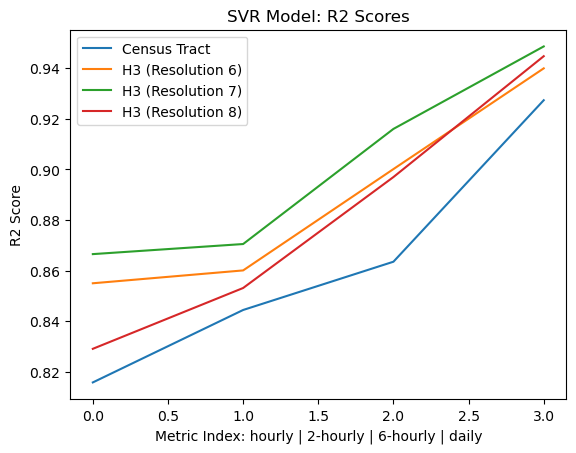

In [157]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the R2 scores for different models
ax.plot(svm_metrics_ct, label='Census Tract')
ax.plot(svm_metrics_h3_6, label='H3 (Resolution 6)')
ax.plot(svm_metrics_h3_7, label='H3 (Resolution 7)')
ax.plot(svm_metrics_h3_8, label='H3 (Resolution 8)')

# Set labels and title
ax.set_xlabel('Metric Index: hourly | 2-hourly | 6-hourly | daily')
ax.set_ylabel('R2 Score')
ax.set_title('SVR Model: R2 Scores')
ax.legend()

# Show the plot
plt.show()
fig.savefig('data/04_prediction_svm_metrics.png')

The results will be discussed in detail in the report. In general, we can observe a trend, that larger time buckets lead to higher performances. The performance of Census Tract and H3 (Res=8) are very similar as well as the performance of H3 (Res=6) and H3 (Res=7). Furthermore, the report will discuss the implications of the models in general regarding the used datasets and of the daily prediction in detail.

## Deep Learning
### Functions

For the deep learning section, we first define the following three functions to build the model (with different hyperparameters as arguments), to perform the grid search, and to evaluate the model with the passed parameters, respectively.

In [179]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

def build_model(optimizer='rmsprop', learning_rate=0.01, neurons=256, activation='relu', hidden_layers=1):
    model = models.Sequential()
    # Input Layer
    model.add(layers.Dense(neurons, activation=activation, input_shape=(x_train_scaled.shape[1],)))
    # Hidden Layers
    for _ in range(hidden_layers):
        model.add(layers.Dense(neurons, activation=activation))
    # Output Layer
    model.add(layers.Dense(1))

    # Optimizer
    if optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

In [180]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def grid_search_DL(x_train_scaled, y_train, build_model, param_grid = {}, batch_size=512, verbose=0):
    if param_grid == {}:
      param_grid = {
        'optimizer': ['rmsprop', 'adam', 'sgd'],
        'learning_rate': [0.01],
        'neurons': [128, 256],
        'hidden_layers': [1, 2],
      }
    # Create a KerasRegressor based on build_model function
    model = KerasRegressor(build_fn=build_model, epochs=10, batch_size=batch_size, verbose=verbose)

    # Create a GridSearchCV instance
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

    # Perform the grid search
    grid_result = grid.fit(x_train_scaled, y_train)  # Make sure to replace x_train_scaled and y_train with your actual data

    # Print the results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    # means = grid_result.cv_results_['mean_test_score']
    # stds = grid_result.cv_results_['std_test_score']
    # params = grid_result.cv_results_['params']
    # for mean, std, param in zip(means, stds, params):
    #     print("%f (%f) with: %r" % (mean, std, param))

In [181]:
def evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, model_params, epochs=30, verbose=0, batch_size=256):
    model = build_model(**model_params)
    model.fit(x_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    test_mse_score, test_mae_score = model.evaluate(x_test_scaled, y_test)

    # Calculate R-squared for the test set predictions
    y_pred = model.predict(x_test_scaled)
    r_squared = r2_score(y_test, y_pred)

    # Print the evaluation metrics
    print("Test MSE:", test_mse_score)
    print("Test MAE:", test_mae_score)
    print("R-squared:", r_squared)
    return r_squared

### Census Tract Feature Set
#### Hourly basis

In [182]:
# Create a list to store metrics for census tract for later comparison
dl_metrics_ct = []

In [183]:
x = feature_set_hourly_ct_subset[input_features_ct]
y = feature_set_hourly_ct_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Grid search
grid_search_DL(x_train_scaled, y_train, build_model)

Best: -189.790251 using {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 128, 'optimizer': 'adam'}


In [184]:
x = feature_set_hourly_ct[input_features_ct]
y = feature_set_hourly_ct['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Evaluate model on test set
params = {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 128, 'optimizer': 'rmsprop'}
r2 = evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, params, batch_size=1024)
dl_metrics_ct.append(r2)

5659/5659 [==============================] - 2s 365us/step
Test MSE: 86.70050048828125
Test MAE: 4.60445499420166
R-squared: 0.8851116421450557


#### 2-hourly basis

In [185]:
x = feature_set_2hourly_ct_subset[input_features_ct]
y = feature_set_2hourly_ct_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Grid search
grid_search_DL(x_train_scaled, y_train, build_model)

Best: -684.983103 using {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}


In [186]:
x = feature_set_2hourly_ct[input_features_ct]
y = feature_set_2hourly_ct['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Evaluate model on test set
params = {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}
r2 = evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, params, batch_size=1024)
dl_metrics_ct.append(r2)

3587/3587 [==============================] - 2s 469us/step
Test MSE: 232.5521697998047
Test MAE: 6.992406845092773
R-squared: 0.9109947471473437


#### 6-hourly basis

In [187]:
x = feature_set_6hourly_ct_subset[input_features_ct]
y = feature_set_6hourly_ct_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Grid search
grid_search_DL(x_train_scaled, y_train, build_model)

Best: -2393.035244 using {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}


In [188]:
x = feature_set_6hourly_ct[input_features_ct]
y = feature_set_6hourly_ct['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Evaluate model on test set
params = {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}
r2 = evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, params, batch_size=512)
dl_metrics_ct.append(r2)

1761/1761 [==============================] - 1s 464us/step
Test MSE: 1063.5419921875
Test MAE: 13.989407539367676
R-squared: 0.9319615029394047


#### Daily basis

In [189]:
# Initializing input and target features
x = feature_set_daily_ct_subset[input_features_ct_daily]
y = feature_set_daily_ct_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Grid search
grid_search_DL(x_train_scaled, y_train, build_model)

Best: -14642.843557 using {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}


In [190]:
# Initializing input and target features
x = feature_set_daily_ct[input_features_ct_daily]
y = feature_set_daily_ct['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Evaluate model on test set
params = {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 128, 'optimizer': 'adam'}
r2 = evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, params, batch_size=32)
dl_metrics_ct.append(r2)

740/740 [==============================] - 0s 327us/step
Test MSE: 7979.77099609375
Test MAE: 34.16728591918945
R-squared: 0.9325633974562613


### H3 Feature Sets
#### Hourly basis

In [191]:
# Initialize the remaining lists that will store the metrics
dl_metrics_h3_6 = []
dl_metrics_h3_7 = []
dl_metrics_h3_8 = []

In [192]:
# Initializing input and target features
x = feature_set_hourly_h3_6_subset[input_features_h3_6]
y = feature_set_hourly_h3_6_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Grid search
grid_search_DL(x_train_scaled, y_train, build_model)

Best: -27789.846869 using {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}


In [193]:
# Initializing input and target features
x = feature_set_hourly_h3_6[input_features_h3_6]
y = feature_set_hourly_h3_6['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Evaluate model on test set
params = {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}
r2 = evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, params, batch_size=128)
dl_metrics_h3_6.append(r2)

2914/2914 [==============================] - 1s 491us/step
Test MSE: 9515.1435546875
Test MAE: 51.2003059387207
R-squared: 0.9285926236637809


In [194]:
# Initializing input and target features
x = feature_set_hourly_h3_7_subset[input_features_h3_7]
y = feature_set_hourly_h3_7_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Grid search
grid_search_DL(x_train_scaled, y_train, build_model)

Best: -5946.841298 using {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}


In [195]:
# Initializing input and target features
x = feature_set_hourly_h3_7[input_features_h3_7]
y = feature_set_hourly_h3_7['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Evaluate model on test set
params = {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}
r2 = evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, params, batch_size=256)
dl_metrics_h3_7.append(r2)

4154/4154 [==============================] - 2s 470us/step
Test MSE: 2343.2744140625
Test MAE: 24.741653442382812
R-squared: 0.9388632177632379


In [196]:
# Initializing input and target features
x = feature_set_hourly_h3_8_subset[input_features_h3_8]
y = feature_set_hourly_h3_8_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Grid search
grid_search_DL(x_train_scaled, y_train, build_model)

Best: -414.570802 using {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}


In [197]:
# Initializing input and target features
x = feature_set_hourly_h3_8[input_features_h3_8]
y = feature_set_hourly_h3_8['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Evaluate model on test set
params = {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}
r2 = evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, params, batch_size=1024)
dl_metrics_h3_8.append(r2)

5190/5190 [==============================] - 2s 459us/step
Test MSE: 169.58641052246094
Test MAE: 6.809940814971924
R-squared: 0.9148245472214839


#### 2-hourly basis

In [198]:
# Initializing input and target features
x = feature_set_2hourly_h3_6_subset[input_features_h3_6]
y = feature_set_2hourly_h3_6_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Grid search
grid_search_DL(x_train_scaled, y_train, build_model)

Best: -108528.255230 using {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}


In [199]:
# Initializing input and target features
x = feature_set_2hourly_h3_6[input_features_h3_6]
y = feature_set_2hourly_h3_6['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Evaluate model on test set
params = {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}
r2 = evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, params, batch_size=32)
dl_metrics_h3_6.append(r2)

1704/1704 [==============================] - 1s 472us/step
Test MSE: 37725.859375
Test MAE: 100.86993408203125
R-squared: 0.9265522611437618


In [200]:
# Initializing input and target features
x = feature_set_2hourly_h3_7_subset[input_features_h3_7]
y = feature_set_2hourly_h3_7_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Grid search
grid_search_DL(x_train_scaled, y_train, build_model)

Best: -22959.258069 using {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}


In [201]:
# Initializing input and target features
x = feature_set_2hourly_h3_7[input_features_h3_7]
y = feature_set_2hourly_h3_7['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Evaluate model on test set
params = {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}
r2 = evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, params, batch_size=128)
dl_metrics_h3_7.append(r2)

2517/2517 [==============================] - 1s 473us/step
Test MSE: 8380.8037109375
Test MAE: 43.52971649169922
R-squared: 0.9415961664285368


In [202]:
# Initializing input and target features
x = feature_set_2hourly_h3_8_subset[input_features_h3_8]
y = feature_set_2hourly_h3_8_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Grid search
grid_search_DL(x_train_scaled, y_train, build_model)

Best: -1553.649159 using {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}


In [203]:
# Initializing input and target features
x = feature_set_2hourly_h3_8[input_features_h3_8]
y = feature_set_2hourly_h3_8['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Evaluate model on test set
params = {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}
r2 = evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, params, batch_size=256)
dl_metrics_h3_8.append(r2)

3255/3255 [==============================] - 2s 473us/step
Test MSE: 580.243408203125
Test MAE: 11.721993446350098
R-squared: 0.9179423924336646


#### 6-hourly basis

In [204]:
# Initializing input and target features
x = feature_set_6hourly_h3_6_subset[input_features_h3_6]
y = feature_set_6hourly_h3_6_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Grid search
grid_search_DL(x_train_scaled, y_train, build_model)

Best: -620647.576008 using {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}


In [205]:
# Initializing input and target features
x = feature_set_6hourly_h3_6[input_features_h3_6]
y = feature_set_6hourly_h3_6['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Evaluate model on test set
params = {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}
r2 = evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, params, batch_size=16)
dl_metrics_h3_6.append(r2)

738/738 [==============================] - 0s 481us/step
Test MSE: 231792.390625
Test MAE: 238.13787841796875
R-squared: 0.9398796133089528


In [206]:
# Initializing input and target features
x = feature_set_6hourly_h3_7_subset[input_features_h3_7]
y = feature_set_6hourly_h3_7_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Grid search
grid_search_DL(x_train_scaled, y_train, build_model)

Best: -116184.120560 using {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}


In [207]:
# Initializing input and target features
x = feature_set_6hourly_h3_7[input_features_h3_7]
y = feature_set_6hourly_h3_7['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Evaluate model on test set
params = {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}
r2 = evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, params, batch_size=64)
dl_metrics_h3_7.append(r2)

1156/1156 [==============================] - 1s 480us/step
Test MSE: 57706.48046875
Test MAE: 119.29684448242188
R-squared: 0.9458298907362939


In [208]:
# Initializing input and target features
x = feature_set_6hourly_h3_8_subset[input_features_h3_8]
y = feature_set_6hourly_h3_8_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Grid search
grid_search_DL(x_train_scaled, y_train, build_model)

Best: -6634.792689 using {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}


In [209]:
# Initializing input and target features
x = feature_set_6hourly_h3_8[input_features_h3_8]
y = feature_set_6hourly_h3_8['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Evaluate model on test set
params = {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}
r2 = evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, params, batch_size=128)
dl_metrics_h3_8.append(r2)

1572/1572 [==============================] - 1s 477us/step
Test MSE: 2823.546875
Test MAE: 23.912185668945312
R-squared: 0.9380878239071523


#### Daily basis

In [210]:
# Initializing input and target features
x = feature_set_daily_h3_6_subset[input_features_h3_6_daily]
y = feature_set_daily_h3_6_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Grid search
grid_search_DL(x_train_scaled, y_train, build_model)

Best: -3833423.874470 using {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'rmsprop'}


In [211]:
# Initializing input and target features
x = feature_set_daily_h3_6[input_features_h3_6_daily]
y = feature_set_daily_h3_6['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Evaluate model on test set
params = {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 128, 'optimizer': 'rmsprop'}
r2 = evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, params, batch_size=16)
dl_metrics_h3_6.append(r2)

247/247 [==============================] - 0s 354us/step
Test MSE: 1736088.5
Test MAE: 615.6874389648438
R-squared: 0.9535474393831112


In [212]:
# Initializing input and target features
x = feature_set_daily_h3_7_subset[input_features_h3_7_daily]
y = feature_set_daily_h3_7_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Grid search
grid_search_DL(x_train_scaled, y_train, build_model)

Best: -681261.133926 using {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}


In [213]:
# Initializing input and target features
x = feature_set_daily_h3_7[input_features_h3_7_daily]
y = feature_set_daily_h3_7['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Evaluate model on test set
params = {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 128, 'optimizer': 'rmsprop'}
r2 = evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, params, batch_size=16)
dl_metrics_h3_7.append(r2)

433/433 [==============================] - 0s 336us/step
Test MSE: 360873.8125
Test MAE: 252.1482391357422
R-squared: 0.964151796293799


In [214]:
# Initializing input and target features
x = feature_set_daily_h3_8_subset[input_features_h3_8_daily]
y = feature_set_daily_h3_8_subset['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Grid search
grid_search_DL(x_train_scaled, y_train, build_model)

Best: -31392.116419 using {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}


In [215]:
# Initializing input and target features
x = feature_set_daily_h3_8[input_features_h3_8_daily]
y = feature_set_daily_h3_8['trips']

# Split dataset and scale features
x_train_scaled, y_train, x_test_scaled, y_test = split_and_scale(x, y, 0.3)

# Evaluate model on test set
params = {'hidden_layers': 2, 'learning_rate': 0.01, 'neurons': 256, 'optimizer': 'adam'}
r2 = evaluate_model(x_train_scaled, y_train, x_test_scaled, y_test, build_model, params, batch_size=32)
dl_metrics_h3_8.append(r2)

643/643 [==============================] - 0s 480us/step
Test MSE: 18700.92578125
Test MAE: 57.37240982055664
R-squared: 0.9489842357092666


#### Summary Deep Learning

To compare the above trained and evaluated models, we will compare the resulting metrics, in the form of R2 scores, that we stored in the corresponding lists. The values in the lists will be in the following order: [hourly, 2-hourly, 6-hourly, daily]

In [216]:
print('R2 Scores for Census Tract:', dl_metrics_ct)
print('R2 Scores for H3 Res=6    :', dl_metrics_h3_6)
print('R2 Scores for H3 Res=7    :', dl_metrics_h3_7)
print('R2 Scores for H3 Res=8    :', dl_metrics_h3_8)

R2 Scores for Census Tract: [0.8851116421450557, 0.9109947471473437, 0.9319615029394047, 0.9325633974562613]
R2 Scores for H3 Res=6    : [0.9285926236637809, 0.9265522611437618, 0.9398796133089528, 0.9535474393831112]
R2 Scores for H3 Res=7    : [0.9388632177632379, 0.9415961664285368, 0.9458298907362939, 0.964151796293799]
R2 Scores for H3 Res=8    : [0.9148245472214839, 0.9179423924336646, 0.9380878239071523, 0.9489842357092666]


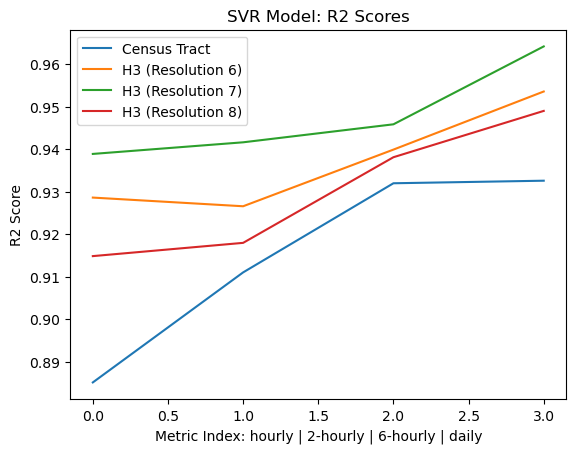

In [217]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the R2 scores for different models
ax.plot(dl_metrics_ct, label='Census Tract')
ax.plot(dl_metrics_h3_6, label='H3 (Resolution 6)')
ax.plot(dl_metrics_h3_7, label='H3 (Resolution 7)')
ax.plot(dl_metrics_h3_8, label='H3 (Resolution 8)')

# Set labels and title
ax.set_xlabel('Metric Index: hourly | 2-hourly | 6-hourly | daily')
ax.set_ylabel('R2 Score')
ax.set_title('SVR Model: R2 Scores')
ax.legend()

# Show the plot
plt.show()
fig.savefig('data/04_prediction_dl_metrics.png')

The results will be discussed in detail in the report. In general, we can observe the same trend as with SVM, that larger time buckets lead to higher performances. The performance of Census Tract and H3 (Res=8) are very similar as well as the performance of H3 (Res=6) and H3 (Res=7). Also the R-squared scores of the deep learning models in general appear to be higher than the ones obtained with SVM regression, which is also influenced by the fact that we only used subsets of the data to train the SVM models (since the whole datasets are too large and thus not compatible).